In [1]:
print("Kernel test succesful")

Kernel test succesful


# EDA for Anime Recommendation System

In [2]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

2025-07-11 10:38:11.926335: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 10:38:12.130026: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 10:38:12.314014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752210492.512212   60685 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752210492.556991   60685 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752210492.930256   60685 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Reading animeist.csv 

In [3]:
import os

INPUT_DIR =  os.path.join("..","artifacts","raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True,usecols=["user_id","anime_id","rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

### Data Processing

In [7]:
n_ratings = rating_df["user_id"].value_counts()

In [8]:
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [9]:
### removing new users

rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>400].index)].copy()
len(rating_df)

3242641

In [10]:
min_rating=min(rating_df["rating"])
min_rating

0

In [11]:
max_rating=max(rating_df["rating"])
max_rating

10

In [12]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(4.122023992171813)

In [13]:
## applying min-max scaling
rating_df["rating"]=rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [14]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(0.41220239921718105)

In [15]:
rating_df.duplicated().sum()

np.int64(0)

In [16]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [17]:
#encoding user_ids
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i,x in enumerate(user_ids)}
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [18]:
# decoding user_id
user2user_decoded = {i : x for i,x in enumerate(user_ids)}
user2user_decoded

{0: 2,
 1: 6,
 2: 12,
 3: 16,
 4: 17,
 5: 19,
 6: 21,
 7: 41,
 8: 42,
 9: 44,
 10: 47,
 11: 53,
 12: 55,
 13: 60,
 14: 66,
 15: 73,
 16: 74,
 17: 85,
 18: 89,
 19: 90,
 20: 94,
 21: 98,
 22: 102,
 23: 108,
 24: 111,
 25: 112,
 26: 120,
 27: 121,
 28: 122,
 29: 135,
 30: 145,
 31: 146,
 32: 147,
 33: 153,
 34: 155,
 35: 156,
 36: 172,
 37: 174,
 38: 184,
 39: 190,
 40: 193,
 41: 194,
 42: 198,
 43: 204,
 44: 205,
 45: 209,
 46: 214,
 47: 219,
 48: 222,
 49: 227,
 50: 228,
 51: 235,
 52: 238,
 53: 240,
 54: 243,
 55: 248,
 56: 251,
 57: 252,
 58: 257,
 59: 264,
 60: 267,
 61: 272,
 62: 274,
 63: 275,
 64: 284,
 65: 285,
 66: 286,
 67: 290,
 68: 291,
 69: 293,
 70: 300,
 71: 301,
 72: 306,
 73: 308,
 74: 310,
 75: 313,
 76: 314,
 77: 316,
 78: 320,
 79: 321,
 80: 324,
 81: 325,
 82: 326,
 83: 327,
 84: 330,
 85: 336,
 86: 340,
 87: 345,
 88: 346,
 89: 349,
 90: 350,
 91: 366,
 92: 367,
 93: 371,
 94: 372,
 95: 375,
 96: 381,
 97: 382,
 98: 386,
 99: 389,
 100: 398,
 101: 405,
 102: 406,
 

In [19]:
rating_df["user"]=rating_df["user_id"].map(user2user_encoded)
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [20]:
n_users = len(user2user_encoded)
n_users

4193

In [21]:
#same ops with anime_id
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i,x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i,x in enumerate(anime_ids)}
rating_df["anime"]=rating_df["anime_id"].map(anime2anime_encoded)

In [22]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [23]:
n_animes = len(anime2anime_encoded)
n_animes

17149

In [24]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [25]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [26]:
test_size = 1000
train_idices = rating_df.shape[0] - test_size

In [27]:
X_train, X_test, y_train, y_test = (
    X[:train_idices],
    X[train_idices:],
    y[:train_idices],
    y[train_idices:],
)

In [28]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3241641, 1000, 3241641, 1000)

In [29]:
type(X_train)

numpy.ndarray

In [30]:
# separating user and anime features in list

X_train_array = [X_train[: , 0], X_train[: ,1]]
X_test_array = [X_test[: , 0], X_test[: , 1]]

type(X_train_array), type(X_train_array[0])

(list, numpy.ndarray)

### Model Architecture

In [31]:
def RecommenderNet():
    embedding_size =128
    
    user = Input(name="user",shape=[1])   
    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)
    
    anime =  Input(name="anime", shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_animes, output_dim=embedding_size)(anime)
    
    x = Dot(name ="dot_product", normalize=True, axes=2)([user_embedding,anime_embedding])
    
    x = Flatten()(x)
    
    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy", metrics=["mae","mse"],optimizer='Adam')
    return model
    
    

In [32]:
model = RecommenderNet()
model.summary()


2025-07-11 10:38:30.767068: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    536,704 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,731,782 (10.42 MB)

 Trainable params: 2,731,780 (10.42 MB)

 Non-trainable params: 2 (8.00 B)

In [33]:
start_learning_rate = 0.00001
min_learning_rate = 0.0001
max_learning_rate = 0.00005
batch_size =  10000
ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_learning_rate-start_learning_rate)/ramup_epochs*epoch + start_learning_rate
    elif epoch<ramup_epochs+sustain_epochs:
        return max_learning_rate
    else:
        return (max_learning_rate)*exp_decay** (epoch-ramup_epochs-sustain_epochs)+min_learning_rate
    

In [34]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch),verbose=0)
checkpoint_filepath = "./weights.weights.h5"

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)

early_stopping = EarlyStopping(patience=5,monitor='val_loss',mode='min',restore_best_weights=True)

In [35]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

### Model Training

In [36]:
history = model.fit(
    x =  X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - loss: 0.7483 - mae: 0.3725 - mse: 0.1795 - val_loss: 0.6952 - val_mae: 0.3570 - val_mse: 0.1550 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - loss: 0.7452 - mae: 0.3715 - mse: 0.1782 - val_loss: 0.7219 - val_mae: 0.3614 - val_mse: 0.1672 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - loss: 0.7404 - mae: 0.3696 - mse: 0.1760 - val_loss: 0.7398 - val_mae: 0.3652 - val_mse: 0.1743 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 29s 88ms/step - loss: 0.7335 - mae: 0.3670 - mse: 0.1731 - val_loss: 0.7375 - val_mae: 0.3647 - val_mse: 0.1733 - learning_rate: 3.4000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - loss: 0.7244 - mae: 0.3634 - mse: 0.1690 - val_loss: 0.7320 - val_mae: 0.3633 - val_mse: 0.1710 - learning_rate: 4.2000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - loss: 0.7085 - mae: 0.3572 - mse: 0.1621 - v

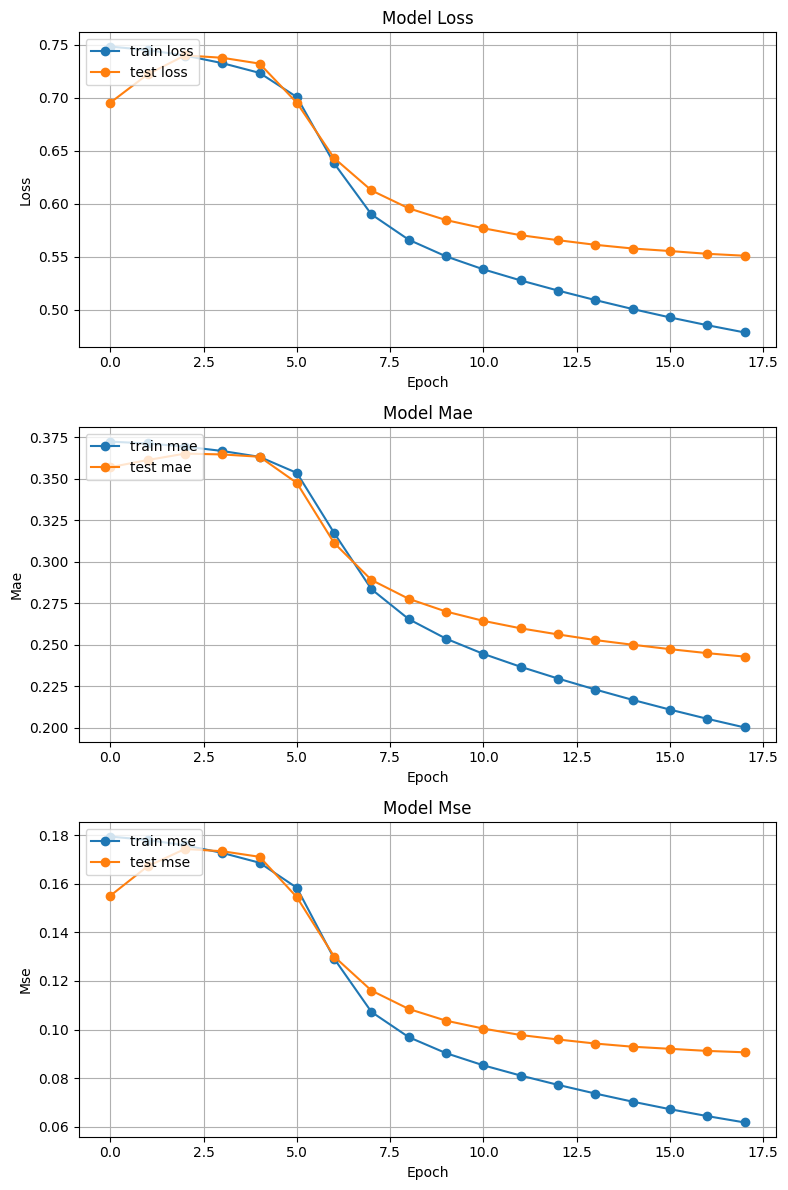

In [37]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [38]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1,1))
    return weights

In [39]:
anime_weights = extract_weights("anime_embedding",model)
user_weights = extract_weights("user_embedding",model)

## Reading anime.csv

In [40]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [41]:
# replacing unknown values with nan
df = df.replace("Unknown",np.nan)

In [42]:
# getting names of anime

def getAnimeName(anime_id):
    name = df[df.anime_id == anime_id].eng_version.values[0]
    
    if name is np.nan:
        name = df[df.anime_id == anime_id].Name.values[0]
        
    return name

In [43]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]


In [44]:
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [45]:
getAnimeName(5)

'Cowboy Bebop:The Movie'

In [46]:
df.sort_values(by="Score",
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [47]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [48]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [49]:
df = df[["anime_id","eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [50]:
def getAnimeFrame(anime,df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [51]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


### Reading anime_with_synopsis.csv

In [52]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [53]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols,low_memory=True)

In [54]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [55]:
def getSynopsis(anime,df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [56]:
getSynopsis(40028,synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [57]:
getSynopsis("Witch Hunter Robin",synopsis_df)

"ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"

## Content/Item Based Recommnedation System

In [58]:
pd.set_option("max_colwidth",None)

In [59]:
synopsis_df.head(2)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."


In [60]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [64]:
find_similar_animes(67,anime_weights,anime2anime_encoded,anime2anime_decoded,df, synopsis_df,n=3)

,name,similarity,genre
2,Mahoraba: Heartful days,0.407677,"Comedy, Drama, Romance, Shounen"
1,Kurozuka,0.407614,"Action, Drama, Historical, Horror, Romance, Sci-Fi, Vampire"
0,Emma:A Victorian Romance,0.406870,"Slice of Life, Historical, Drama, Romance, Seinen"


### User Based Recommendation

In [61]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [70]:
find_similar_users(11880,user_weights,user2user_encoded,user2user_decoded,n=3)

,similar_users,similarity
2,1289,0.460854
1,10820,0.433398
0,11628,0.414927


In [72]:
def show_word_cloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

In [73]:
from collections import defaultdict

def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)
    
    genres_list = []
    for genres in frame['Genres']:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
                
    if plot:
        show_word_cloud(all_genres)
        
    return genres_list

In [74]:
x=getAnimeFrame(1,df)
x

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


In [75]:
getFavGenre(x)

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

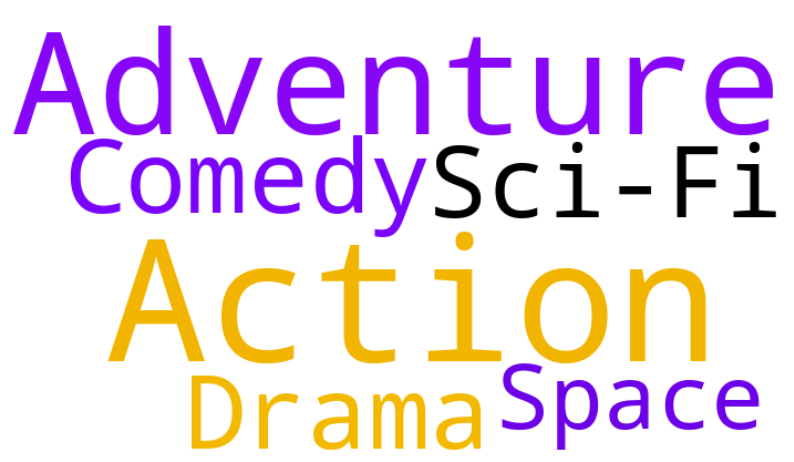

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [76]:
getFavGenre(x,plot=True)

In [78]:
def get_user_preferences(user_id, rating_df, df, plot=False):
    
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user, 75)
    
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user>=user_rating_percentile]
    
    top_animes_user=(
        animes_watched_by_user.sort_values(by='rating',ascending=False).anime_id.values
    )
    
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]
    
    if plot:
        getFavGenre(anime_df_rows, plot)

    return anime_df_rows
        
    
    

In [79]:
get_user_preferences(11880,rating_df, df)

,eng_version,Genres
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7261,Gintama:Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
12242,Gintama Season 5,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7249,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
7577,Monogatari Series:Second Season,"Mystery, Comedy, Supernatural, Romance, Vampire"
...,...,...
11431,Endride,"Adventure, Fantasy"
12479,Saint Seiya: Saintia Shou,"Action, Adventure, Seinen"
11083,Divine Gate,"Action, Sci-Fi, Fantasy"
11304,Dies irae,"Action, Military, Super Power, Magic"


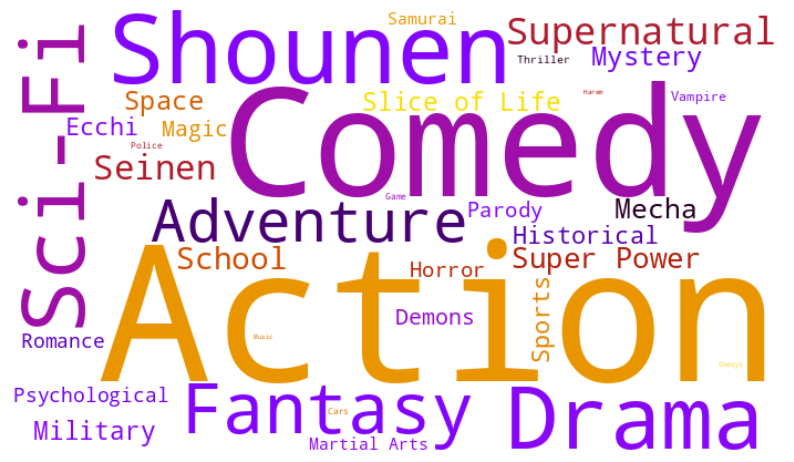

,eng_version,Genres
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7261,Gintama:Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
12242,Gintama Season 5,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7249,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
7577,Monogatari Series:Second Season,"Mystery, Comedy, Supernatural, Romance, Vampire"
...,...,...
11431,Endride,"Adventure, Fantasy"
12479,Saint Seiya: Saintia Shou,"Action, Adventure, Seinen"
11083,Divine Gate,"Action, Sci-Fi, Fantasy"
11304,Dies irae,"Action, Military, Super Power, Magic"


In [80]:
get_user_preferences(11880,rating_df, df,plot=True)

In [86]:
def get_user_recommendation(similar_users, user_pref, df, rating_df, synopsis_df, n=10):
    
    recommended_animes = []
    anime_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)
        
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]
        
        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)
            
    if anime_list:
        anime_list = pd.DataFrame(anime_list)
        
        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts().head(n))
        
        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
            
            if isinstance(anime_name,str):
                frame = getAnimeFrame(anime_name, df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id),synopsis_df)
                
                recommended_animes.append({
                    "n":n_user_pref,
                    "anime_name":anime_name,
                    "Genres":genre,
                    "Synopsis":synopsis
                })
                    
        return pd.DataFrame(recommended_animes).head(n)
                    
                    
        

In [87]:
similar_users = find_similar_users(11880,user_weights,user2user_encoded,user2user_decoded,n=10)

user_pref = get_user_preferences(11880,rating_df, df)

get_user_recommendation(similar_users, user_pref, df, rating_df, synopsis_df)

,n,anime_name,Genres,Synopsis
0,14,Little Witch Academia,"Adventure, Comedy, Fantasy, Magic, School","""A believing heart is your magic!""—these were the words that Atsuko ""Akko"" Kagari's idol, the renowned witch Shiny Chariot, said to her during a magic performance years ago. Since then, Akko has lived by these words and aspired to be a witch just like Shiny Chariot, one that can make people smile. Hence, even her non-magical background does not stop her from enrolling in Luna Nova Magical Academy. However, when an excited Akko finally sets off to her new school, the trip there is anything but smooth. After her perilous journey, she befriends the shy Lotte Yansson and the sarcastic Sucy Manbavaran. To her utmost delight, she also discovers Chariot's wand, the Shiny Rod, which she takes as her own. Unfortunately, her time at Luna Nova will prove to more challenging than Akko could ever believe. She absolutely refuses to stay inferior to the rest of her peers, especially to her self-proclaimed rival, the beautiful and gifted Diana Cavendish, so she relies on her determination to compensate for her reckless behavior and ineptitude in magic. In a time when wizardry is on the decline, Little Witch Academia follows the magical escapades of Akko and her friends as they learn the true meaning of being a witch."
1,10,"No Game, No Life","Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy","No Game No Life is a surreal comedy that follows Sora and Shiro, shut-in NEET siblings and the online gamer duo behind the legendary username ""Blank."" They view the real world as just another lousy game; however, a strange e-mail challenging them to a chess match changes everything—the brother and sister are plunged into an otherworldly realm where they meet Tet, the God of Games. The mysterious god welcomes Sora and Shiro to Disboard, a world where all forms of conflict—from petty squabbles to the fate of whole countries—are settled not through war, but by way of high-stake games. This system works thanks to a fundamental rule wherein each party must wager something they deem to be of equal value to the other party's wager. In this strange land where the very idea of humanity is reduced to child's play, the indifferent genius gamer duo of Sora and Shiro have finally found a real reason to keep playing games: to unite the sixteen races of Disboard, defeat Tet, and become the gods of this new, gaming-is-everything world."
2,10,The Devil is a Part-Timer!,"Comedy, Demons, Supernatural, Romance, Fantasy","Striking fear into the hearts of mortals, the Demon Lord Satan begins to conquer the land of Ente Isla with his vast demon armies. However, while embarking on this brutal quest to take over the continent, his efforts are foiled by the hero Emilia, forcing Satan to make his swift retreat through a dimensional portal only to land in the human world. Along with his loyal general Alsiel, the demon finds himself stranded in modern-day Tokyo and vows to return and complete his subjugation of Ente Isla—that is, if they can find a way back! Powerless in a world without magic, Satan assumes the guise of a human named Sadao Maou and begins working at MgRonald's—a local fast-food restaurant—to make ends meet. He soon realizes that his goal of conquering Ente Isla is just not enough as he grows determined to climb the corporate ladder and become the ruler of Earth, one satisfied customer at a time! Whether it's part-time work, household chores, or simply trying to pay the rent on time, Hataraku Maou-sama! presents a hilarious view of the most mundane aspects of everyday life, all through the eyes of a hapless demon lord."
3,10,One Punch Man 2nd Season,"Action, Sci-Fi, Comedy, Parody, Super Power, Supernatural","In the wake of defeating Boros and his mighty army, Saitama has returned to his unremarkable everyday life in Z-City. However, unbeknownst to him, the number of monsters appearing is still continuously on the rise, putting a strain on the Hero Associa

### Hybrid Recommender System

In [104]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight=0.5):
    # User Recommendation
    similar_users = find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id,rating_df, df)
    user_recommended_animes=get_user_recommendation(similar_users, user_pref, df, rating_df, synopsis_df)
    
    user_recommended_anime_list=user_recommended_animes["anime_name"].tolist()
    
    # Content Recommendation
    content_recommended_animes = []
    
    for anime in user_recommended_anime_list:
        similar_anime=find_similar_animes(anime,anime_weights,anime2anime_encoded,anime2anime_decoded,df, synopsis_df)
        
        if similar_anime is not None and not similar_anime.empty:
            content_recommended_animes.extend(similar_anime["name"].tolist())
            
        else:
            print(f"No similar animes found for {anime}")
     
    combined_scores = {}
    
    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight   
        
    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight
        
    sorted_animes = sorted(combined_scores.items(), key=lambda x:x[1], reverse=True)
    
    return [anime for anime, score in sorted_animes[:10]]
    
    
    
    

In [105]:
hybrid_recommendation(13994)

['Sword Art Online',
 'Puella Magi Madoka Magica',
 'Nisemonogatari',
 'Wolf Children',
 'The Devil is a Part-Timer!',
 'Another',
 'No Game, No Life',
 "Kuroko's Basketball 2",
 'The Future Diary',
 "Kuroko's Basketball"]